In [20]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

In [21]:
data = pd.read_csv('./train.csv')
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


<bound method NDFrame.head of              date  store  sales
0      2013-01-01      1   1316
1      2013-01-01      2   1742
2      2013-01-01      3   1588
3      2013-01-01      4   1423
4      2013-01-01      5   1032
...           ...    ...    ...
18255  2017-12-31      6   2009
18256  2017-12-31      7   1831
18257  2017-12-31      8   3205
18258  2017-12-31      9   2774
18259  2017-12-31     10   2939

[18260 rows x 3 columns]>

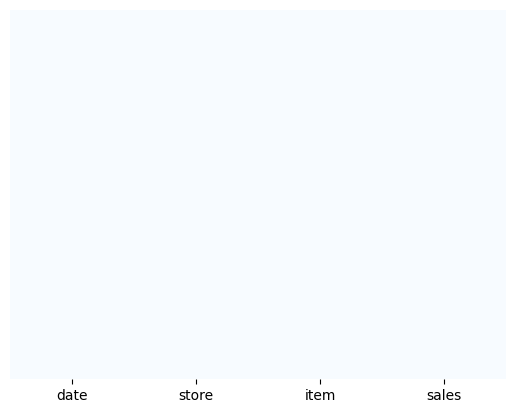

In [22]:
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap="Blues")
data.isnull().sum()
# Elimina la columna 'item'
data = data.drop(columns=['item'])

# Agrupa por 'date' y 'store' y suma las ventas
data = data.groupby(['date', 'store']).sum().reset_index()

data.head

In [23]:
data.columns

Index(['date', 'store', 'sales'], dtype='object')

date
2013-01-01    1316
2013-01-02    1264
2013-01-03    1305
2013-01-04    1452
2013-01-05    1499
Name: sales, dtype: int64

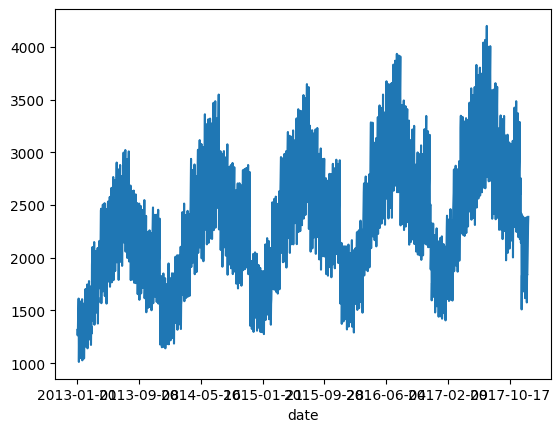

In [24]:
# univariate dataframe: sales vs Time
store_1_data = data[data['store'] == 1]
uni_data_data = store_1_data['sales']
uni_data_data.index = store_1_data['date']
uni_data_data.plot()
uni_data_data.head()

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler  # Agrega esta línea para importar StandardScaler


# Supongamos que 'data' es tu DataFrame original con datos de ventas.
# Asegúrate de que la columna 'date' esté en formato de fecha.
data['date'] = pd.to_datetime(data['date'])

# Divide los datos en conjuntos de entrenamiento, validación y prueba
fecha_fin_prueba = data['date'].max()
fecha_inicio_prueba = fecha_fin_prueba - pd.DateOffset(months=3)
fecha_inicio_validacion = fecha_inicio_prueba - pd.DateOffset(months=6)

conjunto_entrenamiento = data[(data['date'] < fecha_inicio_validacion)]
conjunto_validacion = data[(data['date'] >= fecha_inicio_validacion) & (data['date'] < fecha_inicio_prueba)]
conjunto_prueba = data[(data['date'] >= fecha_inicio_prueba) & (data['date'] <= fecha_fin_prueba)]

# Escala los datos de ventas para tener una media de 0 y desviación estándar de 1
scaler = StandardScaler()
conjunto_entrenamiento['sales'] = scaler.fit_transform(conjunto_entrenamiento['sales'].values.reshape(-1, 1))
conjunto_validacion['sales'] = scaler.transform(conjunto_validacion['sales'].values.reshape(-1, 1))
conjunto_prueba['sales'] = scaler.transform(conjunto_prueba['sales'].values.reshape(-1, 1))

# Genera secuencias para el conjunto de entrenamiento y validación
def generar_secuencias(datos, ventana_historica):
    secuencias = []
    for i in range(len(datos) - ventana_historica - 90):  # 90 días para pronosticar 3 meses
        secuencia = datos[i:i+ventana_historica]
        objetivo = datos[i+ventana_historica:i+ventana_historica+90]
        secuencias.append((secuencia, objetivo))
    return secuencias

ventana_historica = 90  # Por ejemplo, una ventana de 90 días para datos diarios.
secuencias_entrenamiento = generar_secuencias(conjunto_entrenamiento['sales'].values, ventana_historica)
secuencias_validacion = generar_secuencias(conjunto_validacion['sales'].values, ventana_historica)
secuencias_prueba = generar_secuencias(conjunto_prueba['sales'].values, ventana_historica)

# Convierte las secuencias en matrices NumPy
X_entrenamiento, y_entrenamiento = zip(*secuencias_entrenamiento)
X_validacion, y_validacion = zip(*secuencias_validacion)
X_prueba, y_prueba = zip(*secuencias_prueba)

X_entrenamiento = np.array(X_entrenamiento)
y_entrenamiento = np.array(y_entrenamiento)
X_validacion = np.array(X_validacion)
y_validacion = np.array(y_validacion)
X_prueba = np.array(X_prueba)
y_prueba = np.array(y_prueba)

# Define el modelo
modelo = Sequential()
modelo.add(LSTM(units=64, input_shape=(ventana_historica, 1), return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=90, activation='linear'))  # 90 días para pronosticar 3 meses

# Optimizador
opt = Adam(learning_rate=0.001)

# Compila el modelo
modelo.compile(optimizer=opt, loss=Huber(delta=1.0))

# Muestra un resumen del modelo
modelo.summary()

print("Forma de X_entrenamiento:", X_entrenamiento.shape)
print("Forma de y_entrenamiento:", y_entrenamiento.shape)
print("Forma de X_validacion:", X_validacion.shape)
print("Forma de y_validacion:", y_validacion.shape)

print("Ejemplo de X_entrenamiento[0]:")
print(X_entrenamiento[0])
print("Ejemplo de y_entrenamiento[0]:")
print(y_entrenamiento[0])

print("Ejemplo de conjunto_entrenamiento después de escalar:")
print(conjunto_entrenamiento.head())


# Entrena el modelo
modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=50, batch_size=90, verbose=1)

# Evalúa el modelo en el conjunto de prueba
puntuacion = modelo.evaluate(X_prueba, y_prueba, verbose=0)
print("Puntuación en el conjunto de prueba (MSE):", puntuacion)


C:\Users\marco\AppData\Local\Temp\ipykernel_66392\1788271217.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto_entrenamiento['sales'] = scaler.fit_transform(conjunto_entrenamiento['sales'].values.reshape(-1, 1))
C:\Users\marco\AppData\Local\Temp\ipykernel_66392\1788271217.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto_validacion['sales'] = scaler.transform(conjunto_validacion['sales'].values.reshape(-1, 1))
C:\Users\marco\AppData\Local\Temp\ipykernel_66392\1788271217.py:27: Settin

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 64)            16896     
                                                                 
 dropout_2 (Dropout)         (None, 90, 64)            0         
                                                                 
 dense_2 (Dense)             (None, 90, 90)            5850      
                                                                 
Total params: 22,746
Trainable params: 22,746
Non-trainable params: 0
_________________________________________________________________
Forma de X_entrenamiento: (15310, 90)
Forma de y_entrenamiento: (15310, 90)
Forma de X_validacion: (1660, 90)
Forma de y_validacion: (1660, 90)
Ejemplo de X_entrenamiento[0]:
[-1.51383373 -0.97656866 -1.17079124 -1.37888687 -1.87201044 -1.787511
 -1.95777106 -1.12034382 -1.42933429 -1.25529068 -1.57941538 -0.8933

InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/huber_loss/BroadcastGradientArgs_2' defined at (most recent call last):
    File "c:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Program Files\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Program Files\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\marco\AppData\Local\Temp\ipykernel_66392\1788271217.py", line 85, in <module>
      modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=50, batch_size=90, verbose=1)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer.py", line 542, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\marco\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer.py", line 275, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/huber_loss/BroadcastGradientArgs_2'
Incompatible shapes: [10,90,90] vs. [10,90]
	 [[{{node gradient_tape/huber_loss/BroadcastGradientArgs_2}}]] [Op:__inference_train_function_7778]